In [1]:
# Создадим классификатор изображений и обучим его на данных CIFAR-10
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# Определим трансформации для изображений, подаваемых на вход. Это поможет нейросети лучше обучаться и обобщать данные.
# transforms.Normalize имеет два параметра: mean и std соответственно для каждого из трех каналов

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


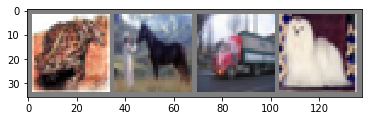

 frog horse truck   dog


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# функция для показа изображения

def imshow(img):
    img = img / 2 + 0.5     # денормализуем
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# получаем несколько случайных тренировочных изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

# показываем изображения
imshow(torchvision.utils.make_grid(images))
# печатаем метки
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Обозначим архитектуру нейронной сети

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


net = Net()
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
# Определим функцию потерь и оптимизатор
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda:0')
net.to(device)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Обучение нейросети

In [7]:
epochs = 2
running_loss = 0
for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        # data - list формата [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Описываем процесс обучения
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Описываем Callbacks, т.е. функции, описывающие как наша сеть обучалась
        running_loss += loss.item()
        if i % 2000 == 1999: # каждые 2000 мини-батчей будем печатать следующую информацию
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Training finished')

[1,  2000] loss: 1.234
[1,  4000] loss: 1.242
[1,  6000] loss: 1.208
[1,  8000] loss: 1.216
[1, 10000] loss: 1.192
[1, 12000] loss: 1.185
[2,  2000] loss: 1.415
[2,  4000] loss: 1.125
[2,  6000] loss: 1.142
[2,  8000] loss: 1.115
[2, 10000] loss: 1.122
[2, 12000] loss: 1.134
Training finished


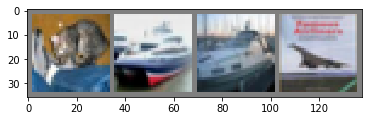

Truth:    cat  ship  ship plane
tensor([3, 8, 8, 0])


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print(labels)

In [10]:
output = net(images.to(device))
output = torch.exp(output)
maxe = torch.max(output, 1)
print(maxe.indices)
print('Prediction: ', ' '.join('%5s' % classes[maxe.indices[j]] for j in range(4)))

tensor([3, 8, 0, 8], device='cuda:0')


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Аккуратность сети на 10000 тестовых изображений: %d %%' % (
    100 * correct / total))

Аккуратность сети на 10000 тестовых изображений: 59 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = torch.exp(net(images))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Аккуратность %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Аккуратность plane : 55 %
Аккуратность   car : 75 %
Аккуратность  bird : 50 %
Аккуратность   cat : 51 %
Аккуратность  deer : 43 %
Аккуратность   dog : 45 %
Аккуратность  frog : 72 %
Аккуратность horse : 64 %
Аккуратность  ship : 76 %
Аккуратность truck : 63 %
